### Variational Auto Encoder
- Variational Auto Encoder (VAE) 는 `Auto-Encoding Variational Bayes` 논문에서 처음 제안되었습니다.
- 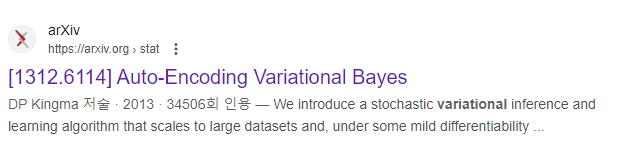
- Auto Encoder 는 입력데이터를 압축하고, 그 데이터를 바로 복원하도록 학습 하는 형태의 모델입니다.
- 그래서 새로운 데이터를 생성하거나, latent 공간에서 의미있는 조작을 하는것에 무리가 있습니다.



### Auto Encoder vs Variational Auto Encoder
 - AE는 입력을 그대로 복구하려고 합니다. (Deterministic)
 - 

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

transform = transforms.ToTensor()

train_dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=128, shuffle=False)

Using: cuda


In [3]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        # 확률 공간을 모사하기 위해서는 평균과 분산이 있으면
        # 가우시안 분포를 그릴 수 있다.
        # 데이터가 가우시안 분포라고 가정 한 거라고 보면 된다...
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, 20) # 평균을 위한 계층
        self.fc22 = nn.Linear(400, 20) # 로그 분산을 위한 계층

        # Decoder
        self.fc3 = nn.Linear(20, 400) 
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # 잡음을 추가함
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x   = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z   = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [4]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [15]:
model_path = "vae.pth"
model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        recon, mu, logvar = model(images)
        loss = loss_function(recon, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[{epoch}/{num_epochs}] loss: {total_loss / len(train_loader.dataset):.6f}")

torch.save(model.state_dict(), model_path)
print("모델 저장 완료:", model_path)

[1/100] loss: 164.265069
[2/100] loss: 121.559682
[3/100] loss: 114.638437
[4/100] loss: 111.598138
[5/100] loss: 109.883276
[6/100] loss: 108.679076
[7/100] loss: 107.800074
[8/100] loss: 107.176920
[9/100] loss: 106.668492
[10/100] loss: 106.204915
[11/100] loss: 105.862397
[12/100] loss: 105.551694
[13/100] loss: 105.267962
[14/100] loss: 105.043834
[15/100] loss: 104.829877
[16/100] loss: 104.638917
[17/100] loss: 104.395329
[18/100] loss: 104.264311
[19/100] loss: 104.104561
[20/100] loss: 103.924324
[21/100] loss: 103.816614
[22/100] loss: 103.714575
[23/100] loss: 103.572499
[24/100] loss: 103.512626
[25/100] loss: 103.395584
[26/100] loss: 103.311491
[27/100] loss: 103.182409
[28/100] loss: 103.096828
[29/100] loss: 103.026012
[30/100] loss: 102.962334
[31/100] loss: 102.876760
[32/100] loss: 102.810801
[33/100] loss: 102.731450
[34/100] loss: 102.669888
[35/100] loss: 102.624820
[36/100] loss: 102.570107
[37/100] loss: 102.425154
[38/100] loss: 102.386823
[39/100] loss: 102.34

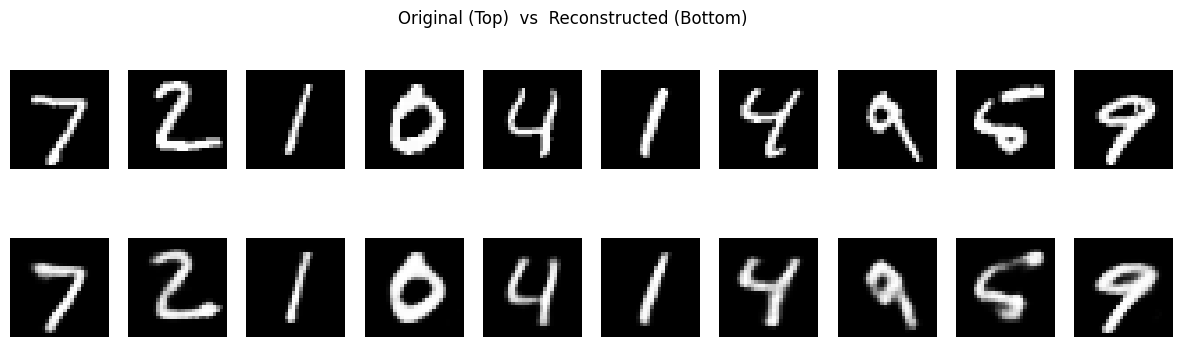

In [16]:
def show_reconstruction(model):
    model.eval()
    images, _ = next(iter(test_loader))
    images = images[:10].to(device)

    with torch.no_grad():
        recon, _, _ = model(images)

    images  = images.cpu()
    recon   = recon.cpu().view(-1, 1, 28, 28)

    plt.figure(figsize=(15, 4))
    for i in range(10):
        # original
        plt.subplot(2, 10, i+1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")

        # reconstructed
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(recon[i].squeeze(), cmap="gray")
        plt.axis("off")

    plt.suptitle("Original (Top)  vs  Reconstructed (Bottom)")
    plt.show()


'''
모델 파일이 이미 있다면, 위의 학습을 진행하지 않아도 된다.
model_path = "vae.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
'''

model.eval()
show_reconstruction(model)

In [17]:
def visualize_latent(model, data_loader, method="pca", max_samples=2000):
    model.eval()

    latents = []
    labels  = []

    with torch.no_grad():
        for images, y in data_loader:
            images = images.to(device)

            mu, logvar = model.encode(images.view(-1, 784))
            latents.append(mu.cpu())
            labels.append(y)

            if sum(len(x) for x in latents) >= max_samples:
                break

    latents = torch.cat(latents)[:max_samples].numpy()
    labels  = torch.cat(labels)[:max_samples].numpy()

    if method == "pca":
        reducer = PCA(n_components=2)
        title = "VAE Latent Space (PCA)"
    else:
        reducer = TSNE(n_components=2, perplexity=30)
        title = "VAE Latent Space (t-SNE)"

    z_2d = reducer.fit_transform(latents)

    plt.figure(figsize=(8, 8))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=labels, cmap="tab10", s=5)
    plt.colorbar()
    plt.title(title)
    plt.show()

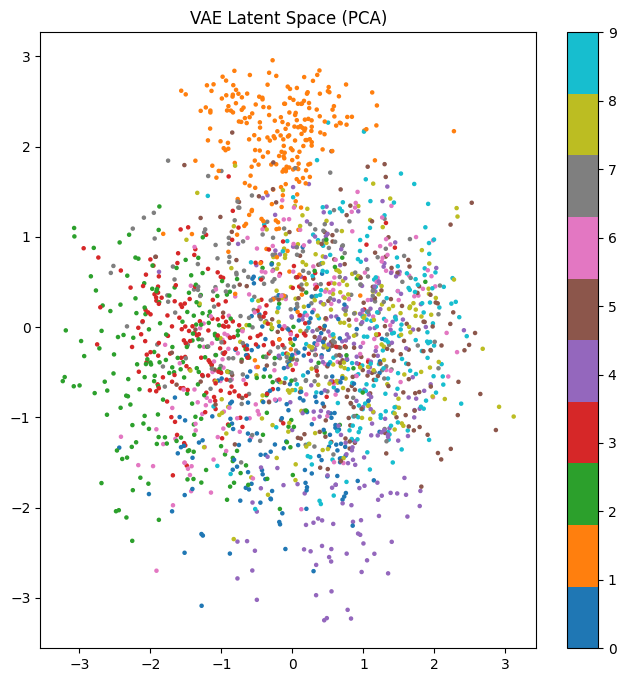

In [18]:
visualize_latent(model, test_loader, method="pca")

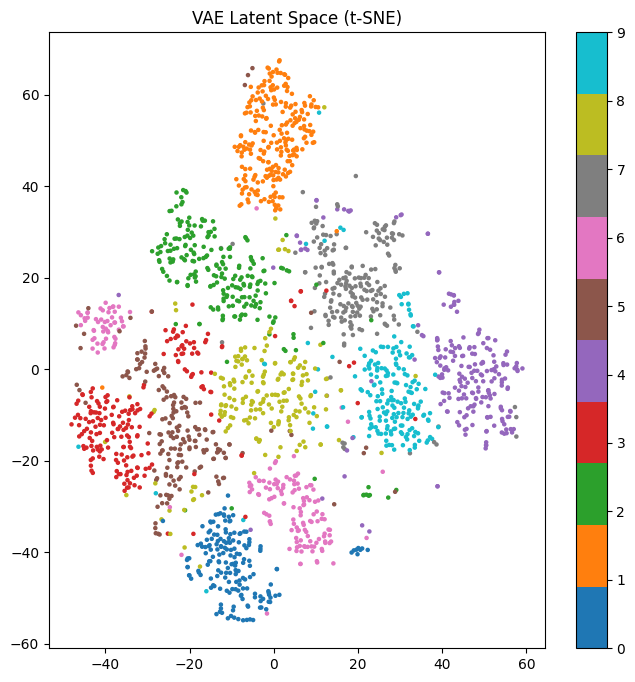

In [19]:
visualize_latent(model, test_loader, method="tsne")

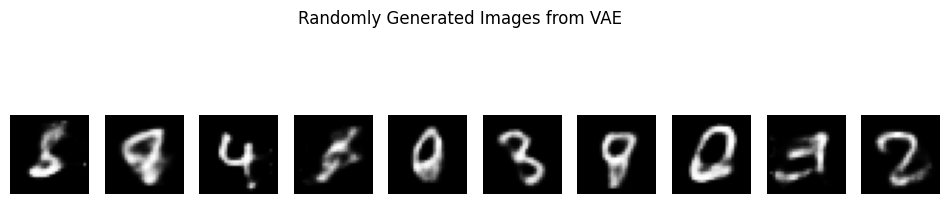

In [20]:
def generate_random_images(model, num=10):
    model.eval()
    z = torch.randn(num, 20).to(device)
    with torch.no_grad():
        samples = model.decode(z).cpu().view(-1, 1, 28, 28)

    plt.figure(figsize=(12, 3))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(samples[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle("Randomly Generated Images from VAE")
    plt.show()

generate_random_images(model, num=10)


In [26]:
def visualize_latent_3d(latents, labels, max_samples=2000):
    latents = latents[:max_samples]
    labels = labels[:max_samples]

    D = latents.shape[1]

    if D != 3:
        print(f"Latent dim = {D}, PCA(3D)로 투영합니다.")
        pca = PCA(n_components=3)
        z = pca.fit_transform(latents)
    else:
        print("Latent dim = 3, 바로 3D로 시각화합니다.")
        z = latents

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    scatter = ax.scatter(
        z[:, 0], z[:, 1], z[:, 2],
        c=labels,
        cmap="tab10",
        s=8,
        alpha=0.8
    )

    ax.set_title("Latent Space 3D Visualization", fontsize=14)
    ax.set_xlabel("z1")
    ax.set_ylabel("z2")
    ax.set_zlabel("z3")
    fig.colorbar(scatter)

    plt.show()

Latent dim = 20, PCA(3D)로 투영합니다.


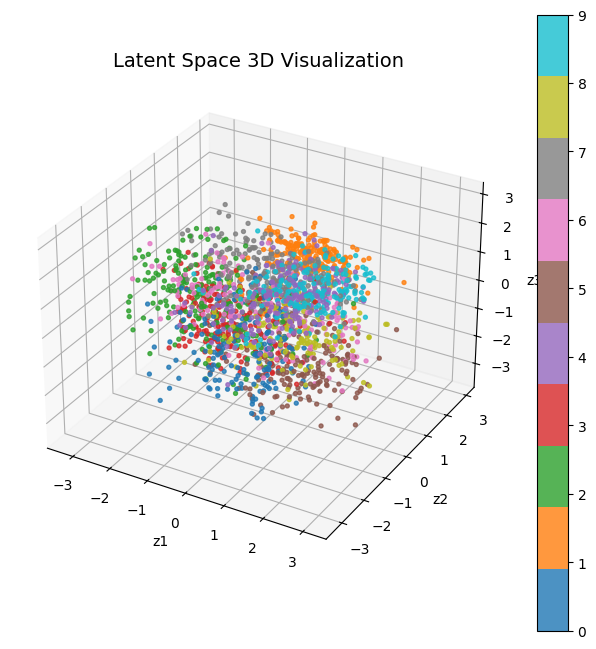

In [27]:
latents = []
labels_list = []

with torch.no_grad():
    for images, y in test_loader:
        images = images.to(device)
        
        # VAE의 경우 latent는 mu 사용 (logvar는 분산 정보)
        mu, logvar = model.encode(images.view(-1, 784))
        latents.append(mu.cpu().numpy())
        labels_list.append(y.numpy())

        if len(latents) * test_loader.batch_size >= 2000:
            break

latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels_list, axis=0)

visualize_latent_3d(latents, labels)